<a href="https://colab.research.google.com/github/SurendraBabu21/Skin-Disease-Detection-using-Deep-Learning-Models/blob/main/Skin_vgg_inceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive/'

 augmented_data		       Dataset	        split_dataset
'Colab Notebooks'	       Dataset_2
'Copy of Copy of DL_1.ipynb'   Final_DL.ipynb


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
data_dir = '/content/drive/MyDrive/Dataset_2'  # Update this to your dataset path

In [ ]:
import tensorflow as tf

dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

num_classes = len(dataset.class_names)
print(f"Number of classes: {num_classes}")


Found 913 files belonging to 3 classes.
Number of classes: 3


In [ ]:
import os

class_counts = {class_name: len(os.listdir(os.path.join(data_dir, class_name)))
                for class_name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, class_name))}

for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


Acne and Rosacea Photos: 326 images
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 322 images
Warts Molluscum and other Viral Infections: 265 images


In [ ]:
import tensorflow as tf
import os

dataset_path = "/content/drive/MyDrive/Dataset"

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = tf.io.read_file(image_path)
            img = tf.io.decode_image(img)
            height, width, _ = img.shape
            print(f"{image_name}: {width}x{height}")


07PerioralDermEye.jpg: 720x472
07PerioralSteroid1.jpg: 720x472
07RosaceaOK0828063.jpg: 480x720
07RosaceaOK0828062.jpg: 720x480
07RosaceaOK082806.jpg: 480x720
07Acne081101.jpg: 720x472
07RosaceaForehead.jpg: 720x472
07AcnePittedScars.jpg: 720x472
07RosaceaTel011204.jpg: 720x472
07PerioralDermNose.jpg: 720x472
07RosaceaK02162.jpg: 472x720
07RosaceaMilia0120.jpg: 472x720
07AcnePittedScars1.jpg: 720x472
07RosaceaFulFAce.jpg: 472x720
07PerioralDermq.jpg: 720x472
07rosacea010206OK.jpg: 720x480
07RosaceaK0216.jpg: 472x720
07RosaceaK02161.jpg: 472x720
ComedonesEars-1.jpg: 720x472
Hidradenitis-Suppurativa-Areola-2.jpg: 720x472
Sebaceous-glands-Areola-1.jpg: 720x472
Sebaceous-glands-Areola-3.jpg: 720x472
Sebaceous-glands-Areola-2.jpg: 720x472
Comedones-Ears.jpg: 720x472
acne-cystic-105.jpg: 720x472
acne-cystic-115.jpg: 720x485
acne-cystic-109.jpg: 484x720
acne-cystic-112.jpg: 470x720
acne-cystic-108.jpg: 720x472
acne-cystic-114.jpg: 720x487
acne-cystic-113.jpg: 720x478
acne-cystic-106.jpg: 720x4

In [ ]:
pip install split-folders

In [ ]:
import splitfolders  # Library for dataset splitting

# Define dataset path (original folder containing class folders)
dataset_path = "/content/drive/MyDrive/Dataset_2"

# Output directory (where train & test datasets will be saved)
output_path = "path/to/split_dataset"

# Perform the split (80% train, 20% test)
splitfolders.ratio(dataset_path, output=output_path, seed=42, ratio=(0.8, 0.2))

print("✅ Dataset successfully split into train & test sets!")


Copying files: 913 files [00:22, 41.29 files/s]

✅ Dataset successfully split into train & test sets!


In [ ]:
def count_images(dataset_path):
    total_images = 0
    class_image_counts = {}

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):  # Check if it's a folder (class)
            num_images = len(os.listdir(class_path))  # Count images in class
            class_image_counts[class_name] = num_images
            total_images += num_images

    return total_images, class_image_counts


In [ ]:
# Set your dataset paths
train_path = "/content/path/to/split_dataset/train"
test_path = "/content/path/to/split_dataset/val"

# Count images
train_total, train_classes = count_images(train_path)
test_total, test_classes = count_images(test_path)

# Print results
print(f"📌 Total Train Images: {train_total}")
print("Train Images per Class:", train_classes)

print(f"\n📌 Total Test Images: {test_total}")
print("Test Images per Class:", test_classes)


📌 Total Train Images: 729
Train Images per Class: {'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 257, 'Warts Molluscum and other Viral Infections': 212, 'Acne and Rosacea Photos': 260}

📌 Total Test Images: 184
Test Images per Class: {'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 65, 'Warts Molluscum and other Viral Infections': 53, 'Acne and Rosacea Photos': 66}


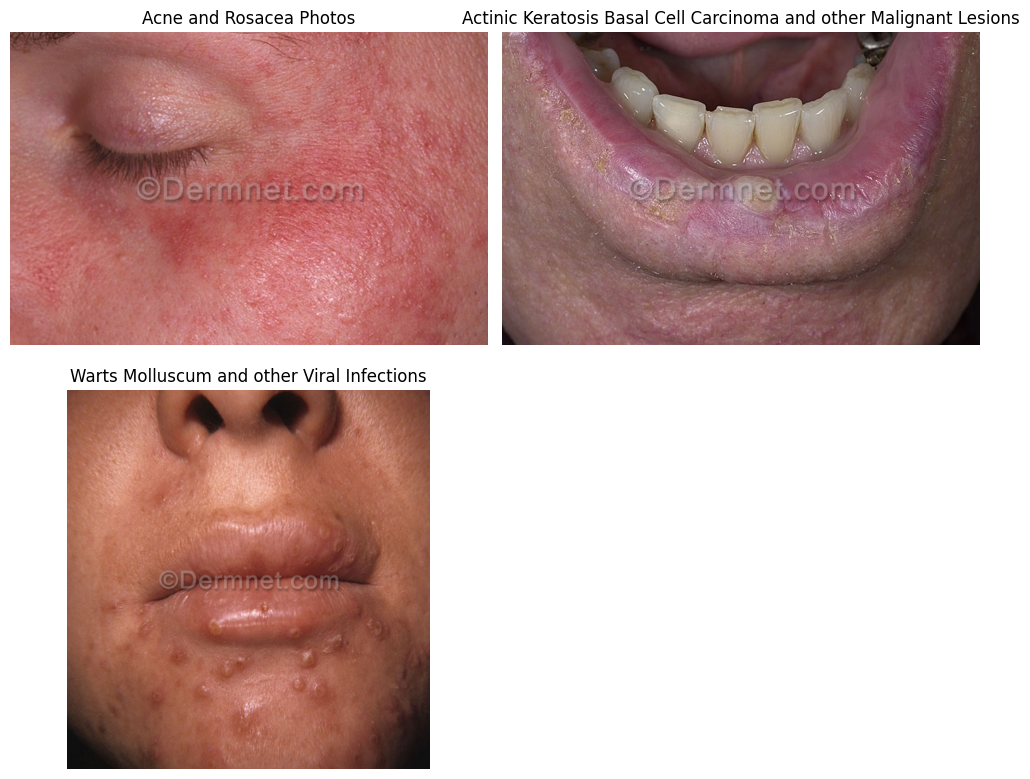

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

def get_sample_images(dataset_path):
    sample_images = {}  # Dictionary to store sample images from each class

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):  # Ensure it's a folder
            images = os.listdir(class_path)

            if images:  # Check if images exist in the folder
                sample_image = random.choice(images)  # Pick a random image
                sample_images[class_name] = os.path.join(class_path, sample_image)

    return sample_images

def display_sample_images(dataset_path):
    sample_images = get_sample_images(dataset_path)

    num_classes = len(sample_images)
    num_cols = 2  # Fixed to 2 columns
    num_rows = math.ceil(num_classes / num_cols)  # Calculate required rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 4))
    axes = axes.flatten()  # Flatten in case of single row

    for ax, (class_name, image_path) in zip(axes, sample_images.items()):
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.set_title(class_name, fontsize=12)
        ax.axis("off")

    # Hide any extra empty subplots (if num_classes is odd)
    for i in range(len(sample_images), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
dataset_path = "/content/drive/MyDrive/Dataset_2"  # Change this to your dataset path
display_sample_images(dataset_path)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Dataset Paths
train_data_path = "/content/path/to/split_dataset/train"  # Update this
test_data_path = "/content/path/to/split_dataset/val"    # Separate test dataset

# Get the number of classes dynamically
num_classes = len(os.listdir(train_data_path))  # Counts the number of subdirectories

# Load VGG16 with pre-trained weights, excluding top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-4:]:  # Unfreezing last 4 layers
    layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Define the model
vgg_model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model with a lower learning rate
vgg_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train & Validation Generators
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)  # No shuffle for evaluation


# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Print detected number of classes
print("Detected Classes:", train_generator.num_classes)


# Train Model using Test Data as Validation
history = vgg_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on Test Dataset
test_loss, test_acc = vgg_model.evaluate(test_generator)
print(f"Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Found 729 images belonging to 3 classes.
Found 184 images belonging to 3 classes.
Detected Classes: 3
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 937ms/step - accuracy: 0.4400 - loss: 2.8478 - val_accuracy: 0.4402 - val_loss: 2.2063 - learning_rate: 1.0000e-04
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 609ms/step - accuracy: 0.5432 - loss: 2.3379 - val_accuracy: 0.5272 - val_loss: 2.0760 - learning_rate: 1.0000e-04
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 600ms/step - accuracy: 0.6485 - loss: 1.9862 - val_accuracy: 0.6141 - val_loss: 1.8554 - learning_rate: 1.0000e-04
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 589ms/step - accuracy: 0.6777 - loss: 1.8415 - val_accuracy: 0.5761 - val_loss: 1.9141 - learning_rate: 1.0000e-04
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 601ms/step - accuracy: 0.6822 - loss: 1.7426 - val_accuracy: 0.6522 - val_loss: 1.7485 - learning_rate: 1.0000e-04
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 593ms/step - accuracy: 0.7430 - loss: 1.6353 - val_accuracy: 0.5924 - v

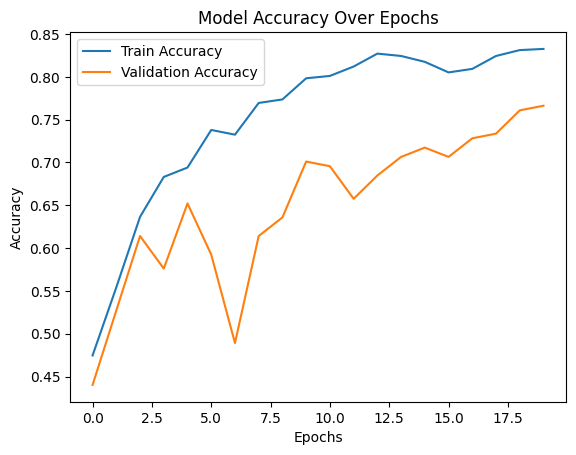

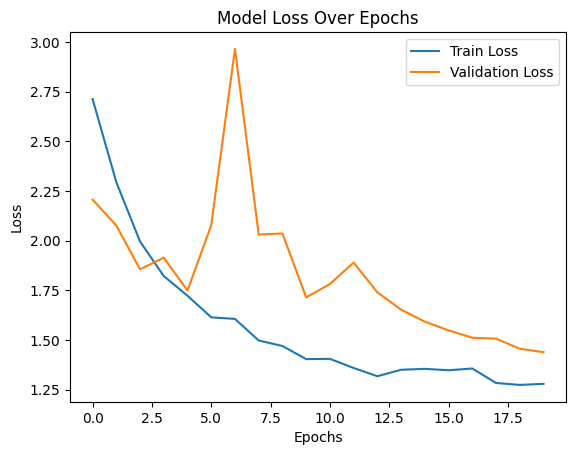

In [ ]:
# ✅ Plot Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

# ✅ Plot Training & Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# Dataset Paths
train_data_path = "/content/path/to/split_dataset/train"  # Update this
test_data_path = "/content/path/to/split_dataset/val"    # Independent test dataset

# Get the number of classes dynamically
num_classes = len(os.listdir(train_data_path))  # Counts the number of subdirectories

# Load InceptionV3 with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 15 layers for fine-tuning
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Define the model
inception_model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model with AdamW optimizer
optimizer = AdamW(learning_rate=0.0003, weight_decay=1e-4)
inception_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


test_datagen = ImageDataGenerator(rescale=1./255)

# Train and Test Generators
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)  # No shuffle for evaluation

# Print detected classes
print("Detected Classes:", train_generator.num_classes)

# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train Model using Test Data as Validation
history = inception_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on Test Dataset
test_loss, test_acc = inception_model.evaluate(test_generator)
print(f"Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Found 729 images belonging to 3 classes.
Found 184 images belonging to 3 classes.
Detected Classes: 3
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.4513 - loss: 1.4705 - val_accuracy: 0.5435 - val_loss: 0.9909 - learning_rate: 3.0000e-04
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 854ms/step - accuracy: 0.6821 - loss: 0.8642 - val_accuracy: 0.6739 - val_loss: 0.7803 - learning_rate: 3.0000e-04
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 931ms/step - accuracy: 0.6826 - loss: 0.8915 - val_accuracy: 0.6304 - val_loss: 0.7511 - learning_rate: 3.0000e-04
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 845ms/step - accuracy: 0.6947 - loss: 0.8975 - val_accuracy: 0.7337 - val_loss: 0.6619 - learning_rate: 3.0000e-04
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 895ms/step - accuracy: 0.7214 - loss: 0.7327 - val_accuracy: 0.7011 - val_loss: 0.6268 - learning_rate: 3.0000e-04
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 840ms/step - accuracy: 0.7649 - loss: 0.6257 - val_accuracy: 0.7554 - val_

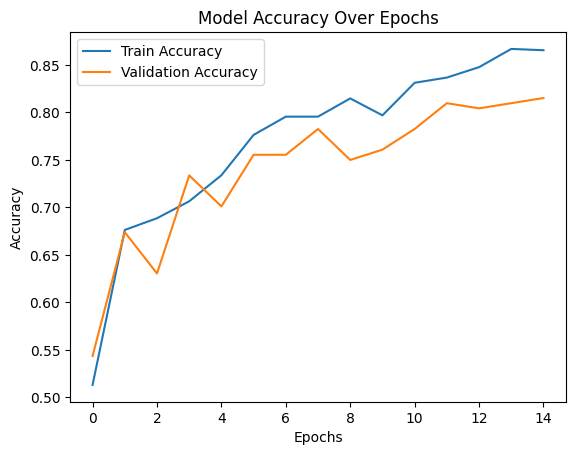

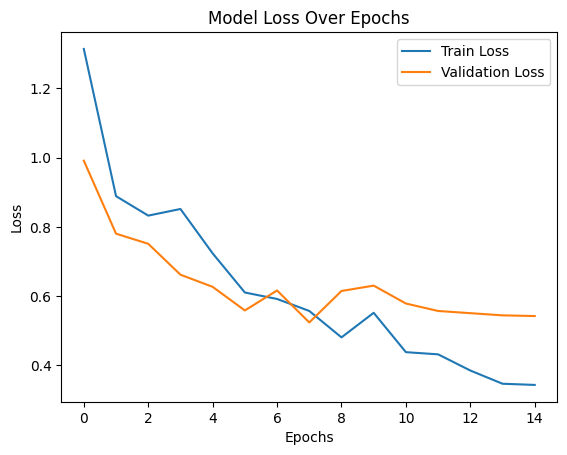

In [ ]:
# ✅ Plot Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

# ✅ Plot Training & Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Load the test dataset
test_data_path = '/content/path/to/split_dataset/val'  # Replace with actual test dataset path

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(299,299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure order is maintained for evaluation
)

# Evaluate model on test set
test_loss, test_accuracy = inception_model.evaluate(test_generator)

# Print test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 184 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.7998 - loss: 0.4389
Test Accuracy: 78.26%


In [ ]:
inception_model.save('/content/skin_disease_model.keras')  # Saves in .h5 format


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


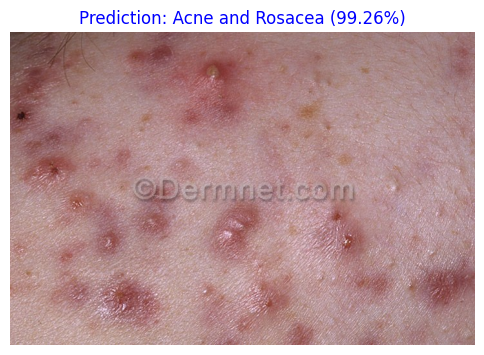

✅ Predicted: Acne and Rosacea (Confidence: 99.26%)


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Load the trained model (update path)
model_path = "/content/skin_disease_model.keras"  # Replace with actual model path
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")

model = tf.keras.models.load_model(model_path)

# Define exactly 3 class labels
class_labels = [
    "Acne and Rosacea",
    "Actinic Keratosis & Malignant Lesions",
    "Warts & Viral Infections"
]

# Function to preprocess the input image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image_resized = cv2.resize(image, (299, 299))  # Resize for model input
    image_norm = image_resized / 255.0  # Normalize pixel values
    image_expanded = np.expand_dims(image_norm, axis=0)  # Add batch dimension
    return image, image_expanded  # Return both original and processed image

# Function to predict skin disease and display image
def predict_and_show(image_path):
    original_image, image_processed = preprocess_image(image_path)

    # Make prediction
    prediction = model.predict(image_processed)
    predicted_class = np.argmax(prediction)  # Get index of highest probability
    confidence = float(prediction[0][predicted_class] * 100)  # Convert to %

    # Ensure valid class mapping
    disease_name = class_labels[predicted_class] if predicted_class < len(class_labels) else "Unknown"

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.axis("off")
    plt.title(f"Prediction: {disease_name} ({confidence:.2f}%)", fontsize=12, color="blue")
    plt.show()

    return disease_name, confidence

# Example Image Path (Update this!)
image_path = "/content/path/to/split_dataset/val/Acne and Rosacea Photos/acne-cystic-115.jpg"  # Replace with actual image path

# Predict and show the result
try:
    disease_name, confidence = predict_and_show(image_path)
    print(f"✅ Predicted: {disease_name} (Confidence: {confidence:.2f}%)")
except Exception as e:
    print(f"❌ Error: {e}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


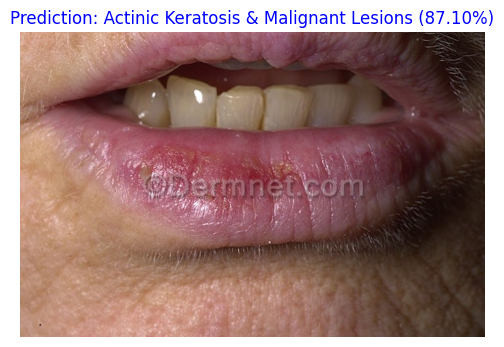

✅ Predicted: Actinic Keratosis & Malignant Lesions (Confidence: 87.10%)


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Load the trained model (update path)
model_path = "/content/skin_disease_model.keras"  # Replace with actual model path
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")

model = tf.keras.models.load_model(model_path)

# Define exactly 3 class labels
class_labels = [
    "Acne and Rosacea",
    "Actinic Keratosis & Malignant Lesions",
    "Warts & Viral Infections"
]

# Function to preprocess the input image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image_resized = cv2.resize(image, (299, 299))  # Resize for model input
    image_norm = image_resized / 255.0  # Normalize pixel values
    image_expanded = np.expand_dims(image_norm, axis=0)  # Add batch dimension
    return image, image_expanded  # Return both original and processed image

# Function to predict skin disease and display image
def predict_and_show(image_path):
    original_image, image_processed = preprocess_image(image_path)

    # Make prediction
    prediction = model.predict(image_processed)
    predicted_class = np.argmax(prediction)  # Get index of highest probability
    confidence = float(prediction[0][predicted_class] * 100)  # Convert to %

    # Ensure valid class mapping
    disease_name = class_labels[predicted_class] if predicted_class < len(class_labels) else "Unknown"

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.axis("off")
    plt.title(f"Prediction: {disease_name} ({confidence:.2f}%)", fontsize=12, color="blue")
    plt.show()

    return disease_name, confidence

# Example Image Path (Update this!)
image_path = "/content/path/to/split_dataset/val/Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions/actinic-cheilitis-sq-cell-lip-54.jpg"  # Replace with actual image path

# Predict and show the result
try:
    disease_name, confidence = predict_and_show(image_path)
    print(f"✅ Predicted: {disease_name} (Confidence: {confidence:.2f}%)")
except Exception as e:
    print(f"❌ Error: {e}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


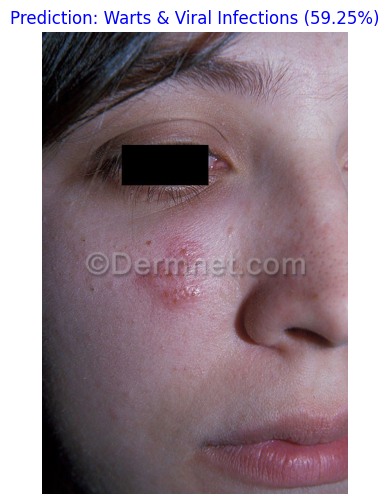

✅ Predicted: Warts & Viral Infections (Confidence: 59.25%)


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Load the trained model (update path)
model_path = "/content/skin_disease_model.keras"  # Replace with actual model path
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")

model = tf.keras.models.load_model(model_path)

# Define exactly 3 class labels
class_labels = [
    "Acne and Rosacea",
    "Actinic Keratosis & Malignant Lesions",
    "Warts & Viral Infections"
]

# Function to preprocess the input image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image_resized = cv2.resize(image, (299, 299))  # Resize for model input
    image_norm = image_resized / 255.0  # Normalize pixel values
    image_expanded = np.expand_dims(image_norm, axis=0)  # Add batch dimension
    return image, image_expanded  # Return both original and processed image

# Function to predict skin disease and display image
def predict_and_show(image_path):
    original_image, image_processed = preprocess_image(image_path)

    # Make prediction
    prediction = model.predict(image_processed)
    predicted_class = np.argmax(prediction)  # Get index of highest probability
    confidence = float(prediction[0][predicted_class] * 100)  # Convert to %

    # Ensure valid class mapping
    disease_name = class_labels[predicted_class] if predicted_class < len(class_labels) else "Unknown"

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.axis("off")
    plt.title(f"Prediction: {disease_name} ({confidence:.2f}%)", fontsize=12, color="blue")
    plt.show()

    return disease_name, confidence

# Example Image Path (Update this!)
image_path = "/content/path/to/split_dataset/val/Warts Molluscum and other Viral Infections/herpes-cutaneous-128.jpg"  # Replace with actual image path

# Predict and show the result
try:
    disease_name, confidence = predict_and_show(image_path)
    print(f"✅ Predicted: {disease_name} (Confidence: {confidence:.2f}%)")
except Exception as e:
    print(f"❌ Error: {e}")


Found 184 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


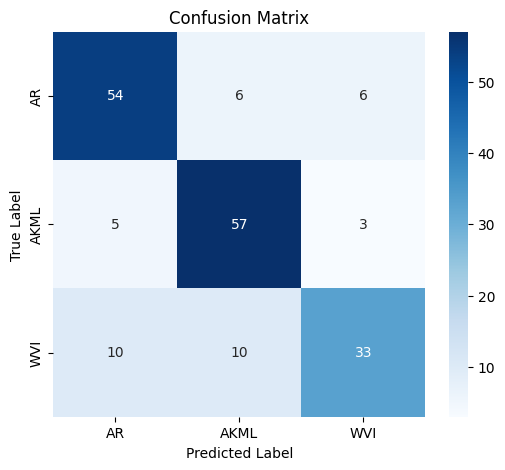

Classification Report:
               precision    recall  f1-score   support

          AR       0.78      0.82      0.80        66
        AKML       0.78      0.88      0.83        65
         WVI       0.79      0.62      0.69        53

    accuracy                           0.78       184
   macro avg       0.78      0.77      0.77       184
weighted avg       0.78      0.78      0.78       184



In [ ]:
import tensorflow as tf
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load the trained model
model_path = "/content/skin_disease_model.keras"  # Update this path
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")

model = tf.keras.models.load_model(model_path)

# Define class labels
class_labels = ["AR",
                "AKML",
                "WVI"]

# Directory for validation dataset (update path)
val_data_path = "/content/path/to/split_dataset/val"  # Update with actual path

# Data generator for validation set
from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: Don't shuffle so we can match predictions correctly
)

# Get ground truth labels
y_true = val_generator.classes  # True labels (numerical)

# Predict on validation dataset
y_pred_probs = model.predict(val_generator)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class indices

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))
